In [2]:
from shared_utilities import *

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:

def plot_models(models, model_names, colors, X, y, height, width, interval, window_size, step):
    mse_tracker = []

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
            for j, ax in enumerate(ax_row):
                seed_index = i * 2 + j
                seed = seed_index * interval 

                current_data = X[seed]
                true_data = y[seed]

                average = np.zeros(step)

                ax.plot(np.arange(window_size), current_data, label='Input')
                ax.plot(np.arange(window_size, window_size+step), true_data, label='Target', c='blue')

                for model in models:
                    try:
                        pred = model.predict(current_data.reshape(1,-1), verbose = 0).squeeze()
                    except:
                        pred = model.predict(current_data.reshape(1,-1)).squeeze()
                    ax.plot(np.arange(window_size, window_size+step), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
                    average += pred

                average /= len(models)

                ax.plot(np.arange(window_size, window_size+step), average, label='Average', c='black', linestyle='--')
                
                if i == 0 and j == 0:  
                    ax.legend(loc='upper left')

                ax.set_title(f"Seed: {seed}")


    plt.tight_layout()
    plt.show()


# Basline

In [9]:
df

,ws,u10,v10,sp,t2m
timestamp,,,,,
2023-01-01 00:00:00,4.489171,-3.817024,2.362833,98417.92565,290.239893
2023-01-01 01:00:00,4.636628,-3.998815,2.346869,98352.09118,289.948103
2023-01-01 02:00:00,4.673456,-4.086285,2.267921,98305.15365,289.904860
2023-01-01 03:00:00,4.579212,-4.094452,2.050523,98262.54412,289.407348
2023-01-01 04:00:00,4.514000,-4.103410,1.881017,98259.67910,289.453951
...,...,...,...,...,...
2023-12-31 19:00:00,6.559499,-5.841485,2.983970,98610.55242,294.500437
2023-12-31 20:00:00,6.452944,-5.797223,2.834200,98643.65252,293.470148
2023-12-31 21:00:00,6.278035,-5.700795,2.629574,98687.05450,293.101528


In [30]:
def window_step(dataset, window_size, step_):
        X, y, = [], []
        for i in range(len(dataset)-window_size - step_):
            feature = dataset[i:i+window_size]
            target = dataset[i+window_size:i+window_size+step_]
            X.append(feature)
            y.append(target)
        else:
            return np.array(X).squeeze(), np.array(y).squeeze()
        
window_size = 24*2
step = 24

df = pd.read_csv(f'ERA5_Data\ERA5_Reanalysis.csv', index_col='timestamp', parse_dates=True)

windows, targets = window_step(df['ws'], window_size, step)

X_train, X_test_, y_train, y_test_ = train_test_split(windows, targets, test_size=0.2, random_state=42)

hidden_size = [64, 32]

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_ = Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    # layers.Flatten(),

    layers.LSTM(hidden_size[0], activation='relu'),  

    layers.Dense(hidden_size[1], activation='relu'),
    layers.Dense(step)  
])

# Compile the model
model_.compile(optimizer='adam', loss='mean_squared_error')

history = model_.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

mse = model_.evaluate(X_test_, y_test_)
print("Mean Squared Error on Test Set:", mse)

Epoch 1/100

174/174 [==============================] - 3s 9ms/step - loss: 5.7131 - val_loss: 2.5813
Epoch 2/100
174/174 [==============================] - 1s 7ms/step - loss: 2.5361 - val_loss: 2.4229
Epoch 3/100
174/174 [==============================] - 1s 7ms/step - loss: 2.4307 - val_loss: 2.3628
Epoch 4/100
174/174 [==============================] - 1s 8ms/step - loss: 2.3781 - val_loss: 2.4314
Epoch 5/100
174/174 [==============================] - 1s 8ms/step - loss: 2.3427 - val_loss: 2.3115
Epoch 6/100
174/174 [==============================] - 1s 7ms/step - loss: 2.3327 - val_loss: 2.2701
Epoch 7/100
174/174 [==============================] - 1s 8ms/step - loss: 2.2743 - val_loss: 2.2183
Epoch 8/100
174/174 [==============================] - 1s 8ms/step - loss: 2.2532 - val_loss: 2.2086
Epoch 9/100
174/174 [==============================] - 1s 8ms/step - loss: 2.2120 - val_loss: 2.2082
Epoch 10/100
174/174 [==============================] - 1s 8ms/step - loss: 2.1947 - val_l

1/1 [==============================] - 0s 18ms/step


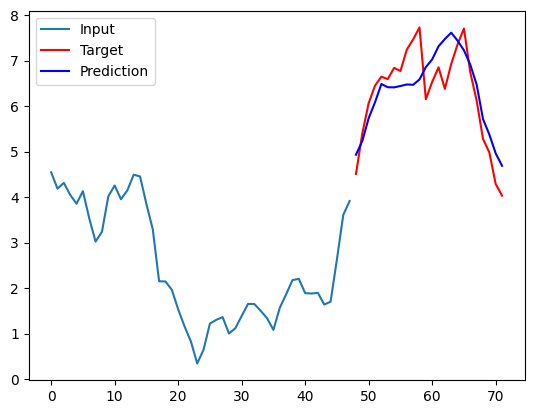

In [41]:
# seed = 0
seed += 1

plt.plot(np.arange(window_size), X_test_[seed], label='Input')
plt.plot(np.arange(window_size, window_size+step), y_test_[seed], label='Target', c='r')
pred = model_.predict(X_test_[seed].reshape(1,-1)).squeeze()
plt.plot(np.arange(window_size, window_size+step), pred, label='Prediction',  c='b')
plt.legend()
plt.show()

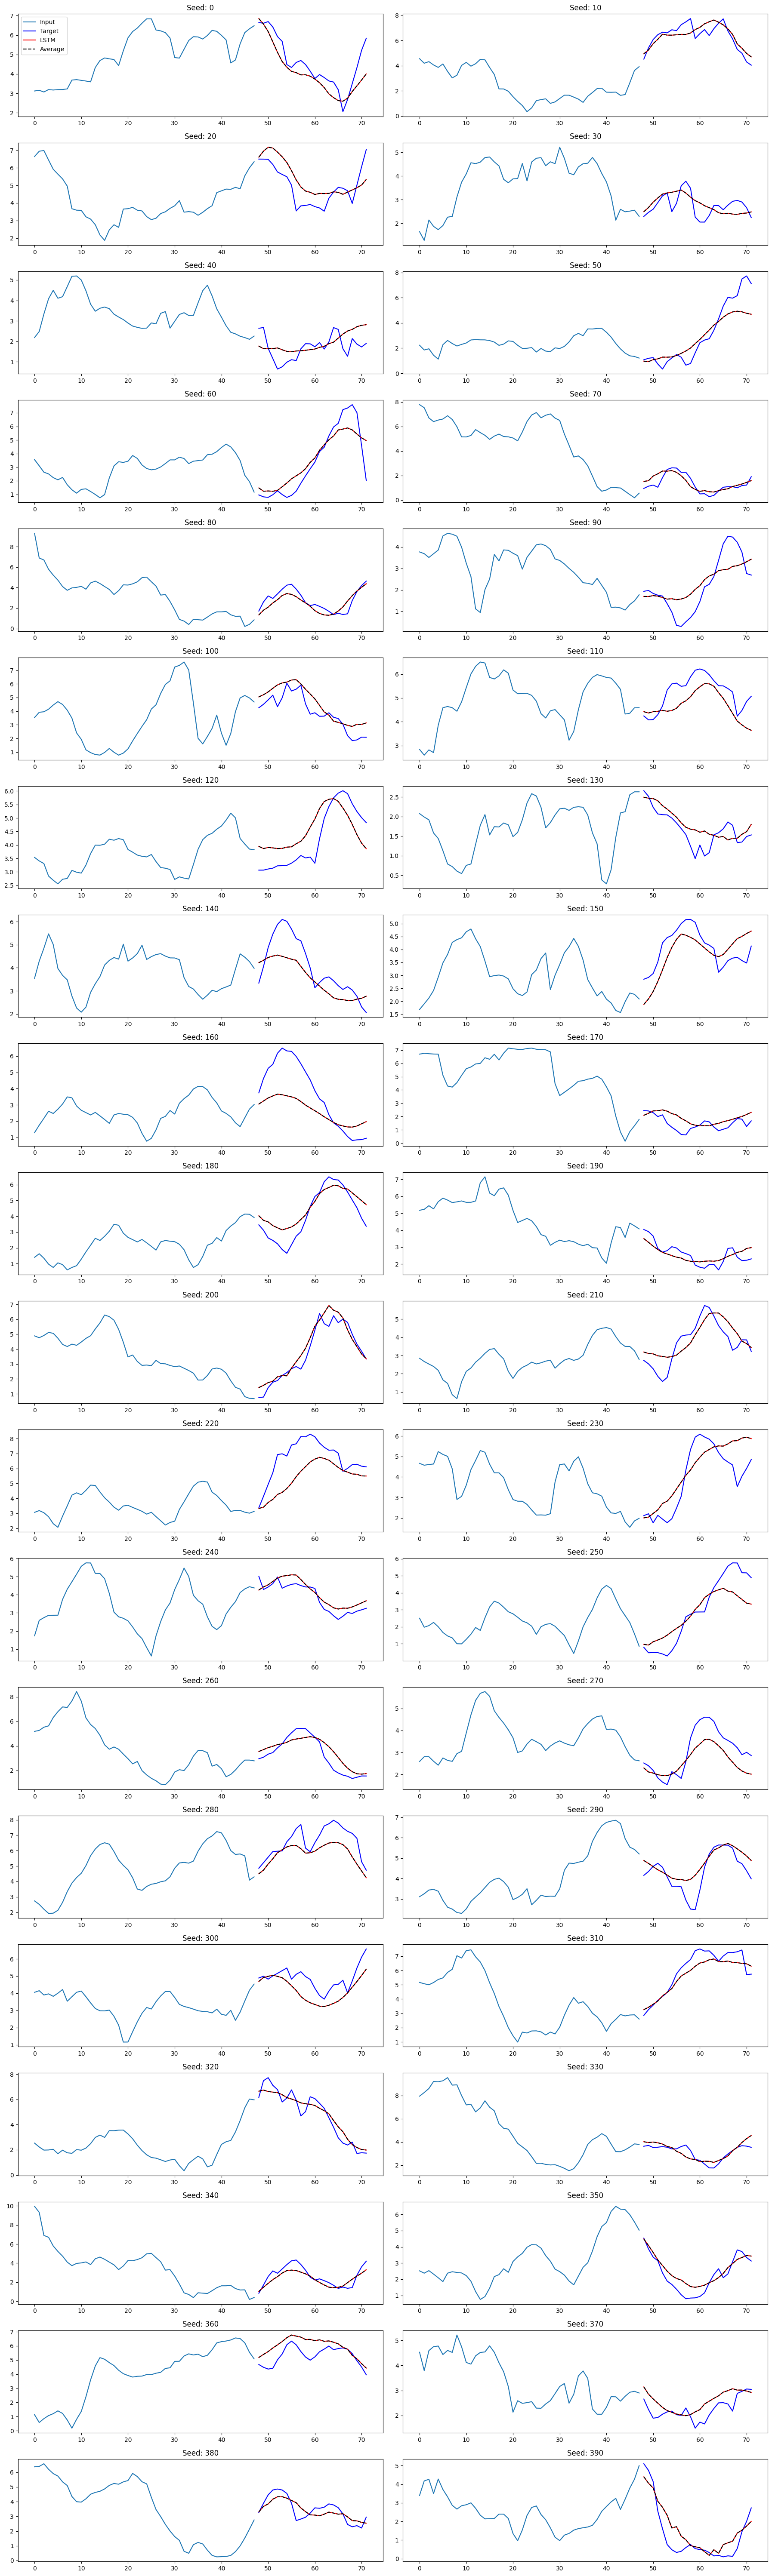

In [42]:
plot_models([model_], ['LSTM'], ['r'], X_test_, y_test_, 20, 2, 10, window_size, step)